Download data and examine

In [2]:
!wget -O data.log.gz 'https://github.com/PaytmLabs/WeblogChallenge/blob/master/data/2015_07_22_mktplace_shop_web_log_sample.log.gz?raw=true'
!gunzip data.log.gz
!head data.log

--2020-02-15 04:36:27--  https://github.com/PaytmLabs/WeblogChallenge/blob/master/data/2015_07_22_mktplace_shop_web_log_sample.log.gz?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/PaytmLabs/WeblogChallenge/raw/master/data/2015_07_22_mktplace_shop_web_log_sample.log.gz [following]
--2020-02-15 04:36:27--  https://github.com/PaytmLabs/WeblogChallenge/raw/master/data/2015_07_22_mktplace_shop_web_log_sample.log.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PaytmLabs/WeblogChallenge/master/data/2015_07_22_mktplace_shop_web_log_sample.log.gz [following]
--2020-02-15 04:36:27--  https://raw.githubusercontent.com/PaytmLabs/WeblogChallenge/master/data/2015_07_22_mktplace_shop_web_log_sample.log.gz
Resolving raw.githubusercontent.com (raw.g

Investigate the out of order issue

In [37]:
from dateutil.parser import parse
from datetime import datetime
import pandas as pd

mark = '2015-07-22T09:00:28.019143Z'
ntschar = len(mark)
epoch = parse(mark)

nskip = len('2015-07-22T09:00:28.019143Z marketpalce-shop ')

tss = []
ips = []
nlines = 20000
with open('data.log') as f:
  for idx, line in enumerate(f):
    if idx > nlines:
      break
    parsed = parse(line[:ntschar])
    tss.append((parsed - epoch).total_seconds())
    ips.append(line[nskip:line.find(':', nskip)])

df = pd.DataFrame.from_dict({'ts': tss, 'ip': ips})

def count_disorder(data):
  data['count_disorder'] = (data['ts'] - data['ts'].shift(1) < 0).sum()
  data['count'] = len(data)
  return data.iloc[0]

agg = df.groupby(['ip']).apply(count_disorder)
agg = agg[agg['count_disorder'] > 0]
print(agg.sort_values(['count_disorder']))
print(agg.sort_values(['count']))

                        ts               ip  count_disorder  count
ip                                                                
14.139.196.4      6.134259     14.139.196.4               1      6
14.139.212.103   13.238470   14.139.212.103               1      3
14.139.217.139   11.948064   14.139.217.139               1      5
14.139.217.165    0.406500   14.139.217.165               1      7
14.139.242.60    17.542776    14.139.242.60               1      6
...                    ...              ...             ...    ...
167.220.236.53   14.544808   167.220.236.53              11     61
103.5.132.5      19.864186      103.5.132.5              11    109
168.235.197.72   27.178087   168.235.197.72              13     70
115.248.214.203   3.955768  115.248.214.203              16     80
168.235.197.179  29.126509  168.235.197.179              21     69

[303 rows x 4 columns]
                        ts               ip  count_disorder  count
ip                                    

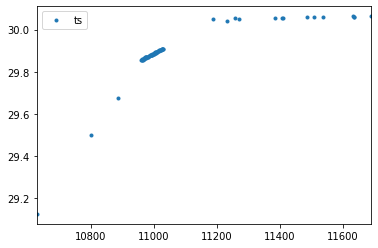

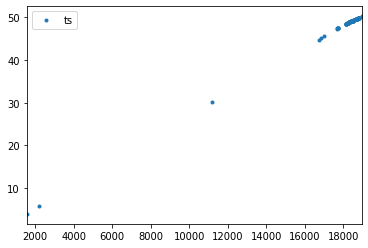

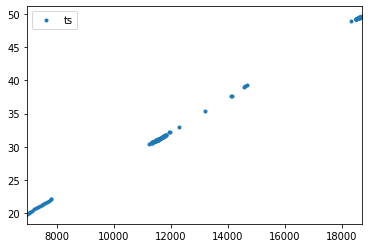

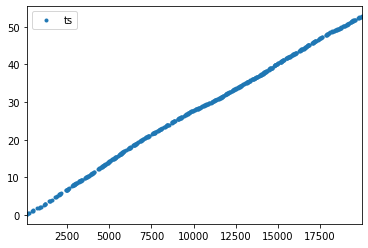

In [42]:
df[df['ip'] == '168.235.197.179'].plot(style='.')
df[df['ip'] == '115.248.214.203'].plot(style='.')
df[df['ip'] == '103.5.132.5'].plot(style='.')
df[df['ip'] == '52.74.219.71'].plot(style='.')

The out of order issue only happens with timestamps very close together, we can mostly treat them as in order for stream processing.